# Part 2: Convolutional Neural Networks

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

In [10]:
import os, re, math, json, shutil, pprint
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import pathlib
from skimage import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.callbacks import History
from sklearn.preprocessing import LabelEncoder
print(tf.__version__)

2.8.2


In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
from os import listdir
from os.path import isfile, join

images = []
labels = []
dataset_path = './MLBD-dataset-IML-2022-Anglo-Saxion-Runes/'
for file_name in listdir(dataset_path):
    full_path = join(dataset_path, file_name)
    if isfile(full_path):
        if re.match(r".*\.png$", full_path):
            image_current = io.imread(full_path, as_gray=True)
            image_label = file_name.split('_')[0].lower()
            # append to the array
            images.append(image_current)
            labels.append(image_label)

Data imbalance 

In the next cell we are going to check for any imbalance in our data

The plot technique is inspired by the following source:
- https://www.kaggle.com/code/saumandas/intro-to-transfer-learning-with-mnist?scriptVersionId=40870403&cellId=11


Text(0.5, 0, 'Rune')

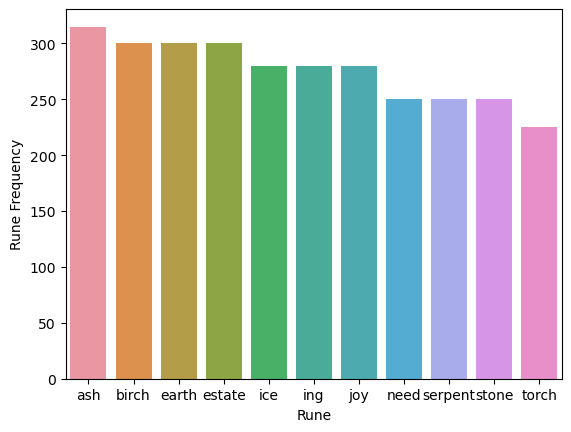

In [69]:
import seaborn as sns
import pandas as pd

orig_labels = pd.DataFrame(labels, columns=['label'])

sns.barplot(x = np.unique(labels), y = orig_labels.value_counts())
plt.ylabel('Rune Frequency')
plt.xlabel('Rune')


We knew from the previous course that the dataset is quite balanced and therefore we will not perform any balancing techniques on the dataset.

We are going to split our data using the train_test_split function from sklearn. We will use 20% of the data for validation and 80% for training.

In [ ]:
from sklearn.model_selection import train_test_split

encoded_labels = keras.utils.to_categorical(LabelEncoder().fit_transform(labels))

X_train, X_test, y_train, y_test = train_test_split(np.array(images), np.array(encoded_labels), test_size=0.2, random_state=123)

We are going to use the following utility function to plot the training and validation loss and accuracy of our models.

In [ ]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.ylim(-0.1, 1.1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

We are going to train our models with 20 epochs of 32 batch size.

The reason of using 32 a batch size of 32 is that the dataset is small and from the sources that we have used we have found that 32 is a good batch size for small datasets. Nevertheless, the epoch are the way the models are improving and having a bigger batch size would not make a big difference unless we have a larger dataset.

Later we will create an early stopper to stop the training when our model is not improving.

source:
- https://stackoverflow.com/a/38405970
- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

Basic method to define the structure of the convolutional neural network

Our structure consists of the following:

1. Input layer with the shape of the image (128, 128, 1)
2. (layers) that would be defined later
3. Flatten layer to flatten the output of the previous layers
4. Dense layer with 512 neurons and relu activation function
5. Desnse layer for our output with 11 neurons (which represents the runes) and softmax activation function

As you can observe, we use the adam optimizer (with default learning rate of 0.001) and the categorical crossentropy loss function and using the metrics for the accuracy.

source: 
- https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

In [123]:
def create_model(layers=[], kernel_size =(3, 3), debug=False):
    model = tf.keras.models.Sequential()
    # Define the input layer 1 channel
    model.add(tf.keras.layers.Input(shape=(128, 128, 1))) 
    
    # Adding convolutional layers
    for layer in layers:
        model.add(layer)

    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())

    # Define the fully connected layer
    model.add(tf.keras.layers.Dense(64, activation='relu'))

    # Output layer with 11 neurons as we have 11 runes to classify
    # which is using the softmax activation function
    model.add(tf.keras.layers.Dense(11, activation='softmax'))

    if (debug):
        model.summary()
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

We're also using the early stopping callback to stop the training if the loss is not decreasing for 3 epochs.

source:
- https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
- https://pub.towardsai.net/keras-earlystopping-callback-to-train-the-neural-networks-perfectly-2a3f865148f7

In [124]:
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='accuracy', baseline=98, patience=3, verbose=1)

In our experiments we are going to use a kernel size of (3,3) for all convolutional layers as we are trying to find local patterns in our runes and preserv the information in the image.
- source: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

In [125]:
kernel_size = (3, 3)

At the same time we would use the Conv2D layer with a certain number fo neurons (64 in this example which would change for some experiments), kernel size of (3,3), which has been defined above and relu activation function.
We are adding the padding same as we would like to capture as much information as possible from the image, even in the corners, where the padding is helpful.

source: 
- https://www.geeksforgeeks.org/keras-conv2d-class/
- https://keras.io/api/layers/convolution_layers/convolution2d/

In [126]:
tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same')

Something that we have noticed during our experiments is that the MaxPooling is boosting the training speed, quite a lot. Then we started reading about it turns out that the MaxPooling is a pooling layer that is used after a convolutional layer. It is used to reduce the spatial dimensions of the output volume of the convolutional layer. It is used to reduce the number of parameters and computation in the network, and hence to also control overfitting. It is also used to some degree to make feature detectors more invariant to their position in the input. 

Therefore, we are going to use the MaxPooling layer with a pool size of (2,2) which would reduce the size of the image by half.


Alex laptop's specifications:
- CPU: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz   2.80 GHz
- RAM: 16.0 GB
- GPU: NVIDIA T500

with this pc configuration we noticed that it takes around ~1 hour to train the model with 15 epochs of 32 batch size, without the MaxPooling layer. We attached a screenshot of the training process.

![Training](./experiment_1_no_maxpooling.png)
![Results](./experiment_1_no_maxpooling_results.png)

Update:
As an observation for the previous statement. We've noticed that we didn't have that problem anymore as we have decreased the neurons in the Dense layer from 512 to 64 and the training time was ~20 minutes.

source:
- https://paperswithcode.com/method/max-pooling#:~:text=Max%20Pooling%20is%20a%20pooling,used%20after%20a%20convolutional%20layer.
- https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

In [127]:
tf.keras.layers.MaxPooling2D((2, 2)),

(<keras.layers.pooling.MaxPooling2D at 0x249ad787ca0>,)

Learning Rate Scheduler
We are going to use a learning rate scheduler to adapt our learning rate each epoch iteration so that we can adjust our learning rate accordingly. From the tests that we conduceted we realized that our model is overfitting quite easy therefore we picked the step decay to decrease the learning rate. 

source:
- https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

In [128]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [129]:
def learning_rate_scheduler():
  return tf.keras.callbacks.LearningRateScheduler(step_decay)

Stores the model and the history of the training

In [130]:
models_and_history = []

# Experiment 1

In the first experiment, we are going to use the following layers:
2 Conv2D layers with 32 filters as a starting point.

Epoch 1/20
76/76 [==============================] - 49s 627ms/step - loss: 1.8928 - accuracy: 0.6295 - val_loss: 0.4072 - val_accuracy: 0.8927
Epoch 2/20
76/76 [==============================] - 49s 647ms/step - loss: 0.1325 - accuracy: 0.9612 - val_loss: 0.2550 - val_accuracy: 0.9323
Epoch 3/20
76/76 [==============================] - 50s 662ms/step - loss: 0.0256 - accuracy: 0.9942 - val_loss: 0.2517 - val_accuracy: 0.9406
Epoch 3: early stopping
76/76 [==============================] - 12s 157ms/step - loss: 0.0067 - accuracy: 1.0000


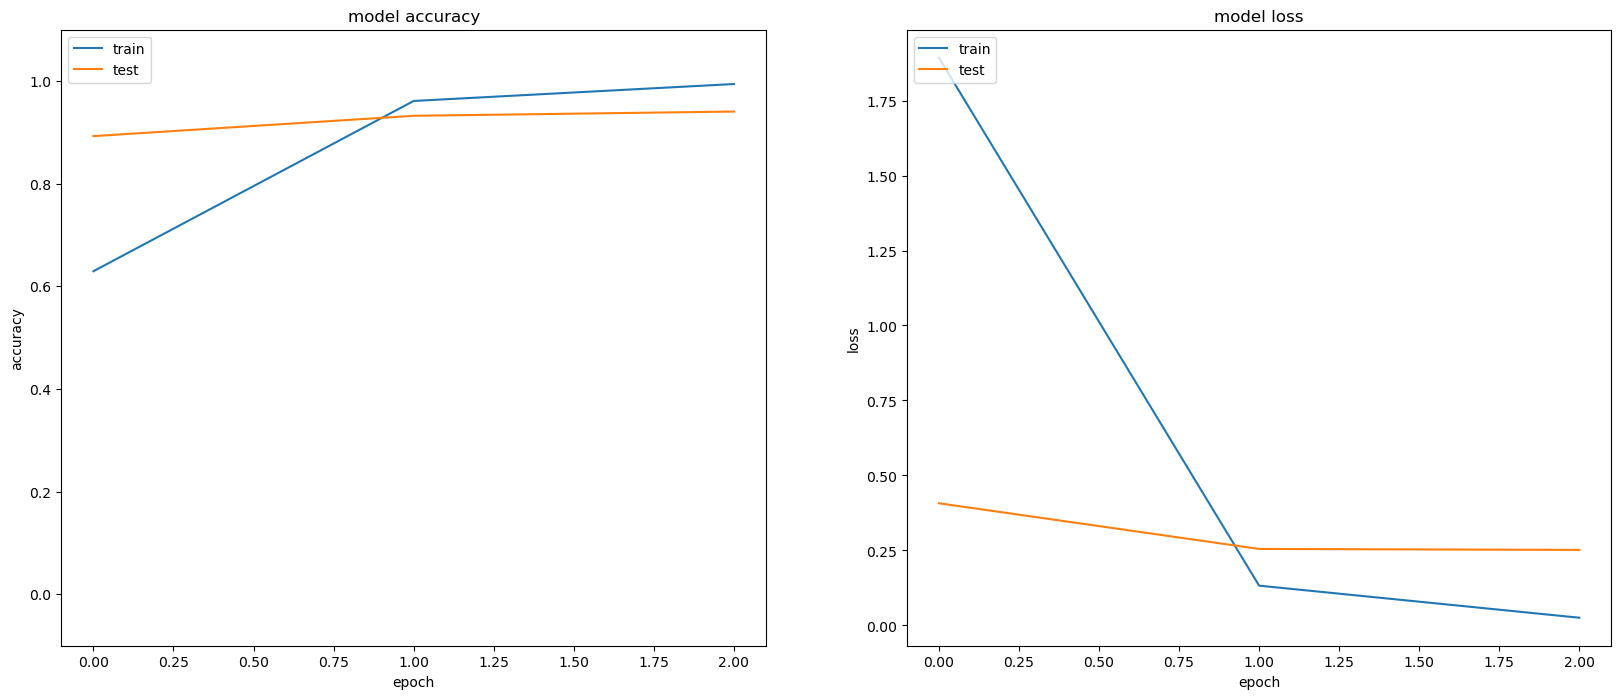

In [47]:
model = create_model(layers=[
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

As far as we can see from the results from our model. The training stopped at the 3rd epoch as the val accuracy has increased from 94%. But the training accuracy is around 99% which means that the model would start to generalize the data and would not be able to predict the test data. Therefore, we are going to keep the model as is. The outcome being that we could train more but as we were told during the lectures the CNN's are overfitting quite easy and we would like to avoid that scenario.

# Experiment 2

In this experiment we have increased the number of neurons to see if we can get better results. Also, added a couple of more conv2D layers.
At the same time we added a MaxPooling layer with a pool size of (2,2) to see if we can reduce the training time, by compresing the data from the conv2d layers. Nevertheless, we added some dropout layers as well to see if ca reduce the number of neurons and allow the model to generalize.

Tthe dropout layer with a rate of 0.2. The dropout layer is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

Epoch 1/20
61/61 [==============================] - 82s 1s/step - loss: 1.4636 - accuracy: 0.4807 - val_loss: 0.5151 - val_accuracy: 0.8495
Epoch 2/20
61/61 [==============================] - 55s 908ms/step - loss: 0.3151 - accuracy: 0.8917 - val_loss: 0.2410 - val_accuracy: 0.9505
Epoch 3/20
61/61 [==============================] - 62s 1s/step - loss: 0.0879 - accuracy: 0.9732 - val_loss: 0.1628 - val_accuracy: 0.9588
Epoch 3: early stopping
19/19 [==============================] - 4s 195ms/step - loss: 0.2196 - accuracy: 0.9604


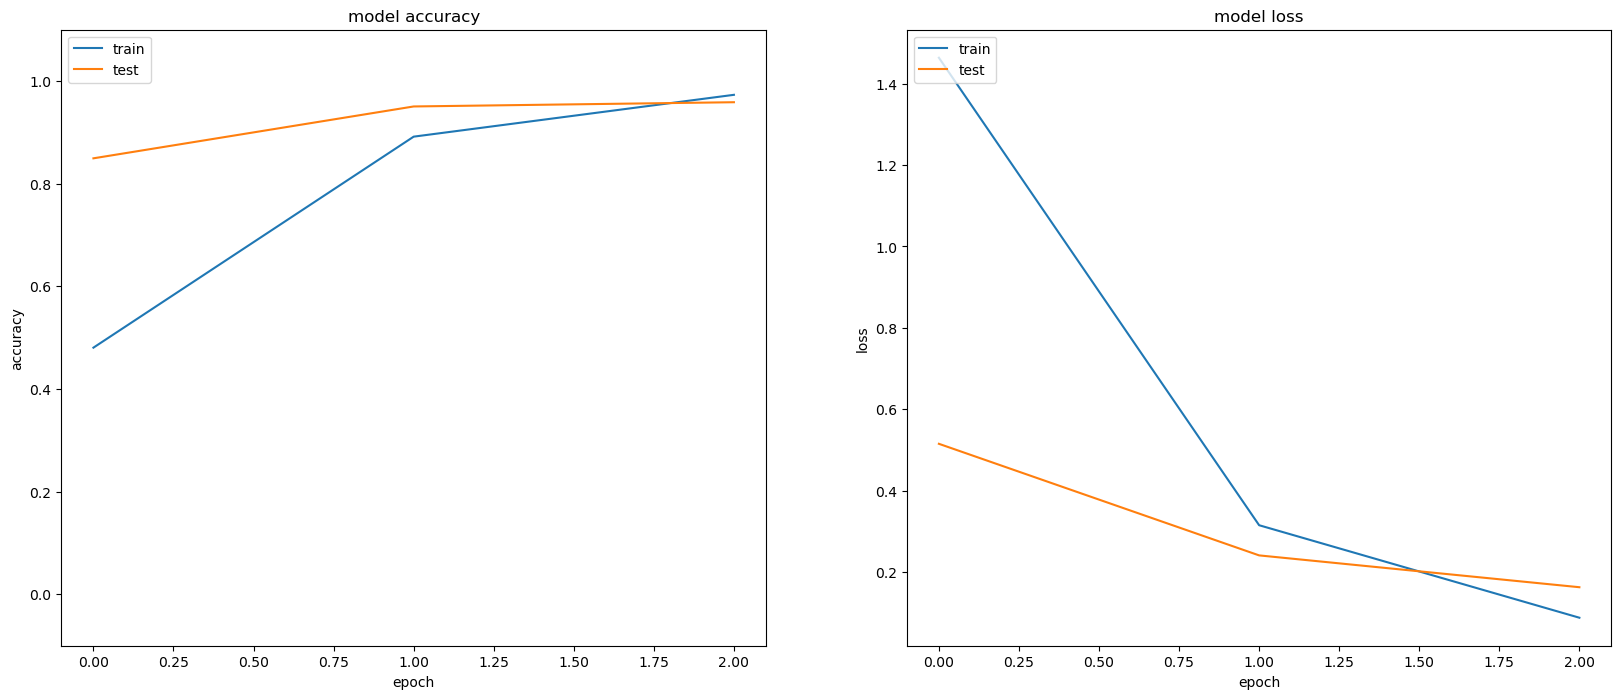

In [137]:
model = create_model(layers=[
    tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding='same'),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

In our second experiment we can see that the early stopping callback was triggered again in the 3rd epoch as we hit the baseline again. From what we can see in the plot the accuracy of the model is around 96% which is not a big improvement compared to the previous experiment. Which made us believe that by adding the maxpooling, droput layers and more conv2D layers has not improved the model necessarily.

# Experiment 3

The third experiment is going to be a bit different to the others, because we wanted to try this convolutions structure that we found on Kaggle. While searching for literature on how to improve the networks that we have obtained from the previous experiments.

Therefore the experiment consists of 5 Conv2D layers with 64, 128 and 256 neurons all with the same kernel size and activation function. Between the convolutional layers you can see we added some maxpooling layers with a pool size of (2,2), we took the liberty to change the model from the kaggle notebook as we wanted kept only the layers that worked for us.

The network structure is based on a kaggle notebook which states that is the best performing structure on the MNIST dataset (which is similar to our).

We are experimenting with this model to see what kind of results we're getting.

source:
- https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook

Epoch 1/20
76/76 [==============================] - 69s 901ms/step - loss: 0.5171 - accuracy: 0.8408 - val_loss: 1.6884 - val_accuracy: 0.8597
Epoch 2/20
76/76 [==============================] - 76s 1s/step - loss: 0.0334 - accuracy: 0.9897 - val_loss: 1.0352 - val_accuracy: 0.9472
Epoch 3/20
76/76 [==============================] - 73s 956ms/step - loss: 0.0119 - accuracy: 0.9955 - val_loss: 1.1472 - val_accuracy: 0.5429
Epoch 3: early stopping
76/76 [==============================] - 20s 259ms/step - loss: 1.0941 - accuracy: 0.5635


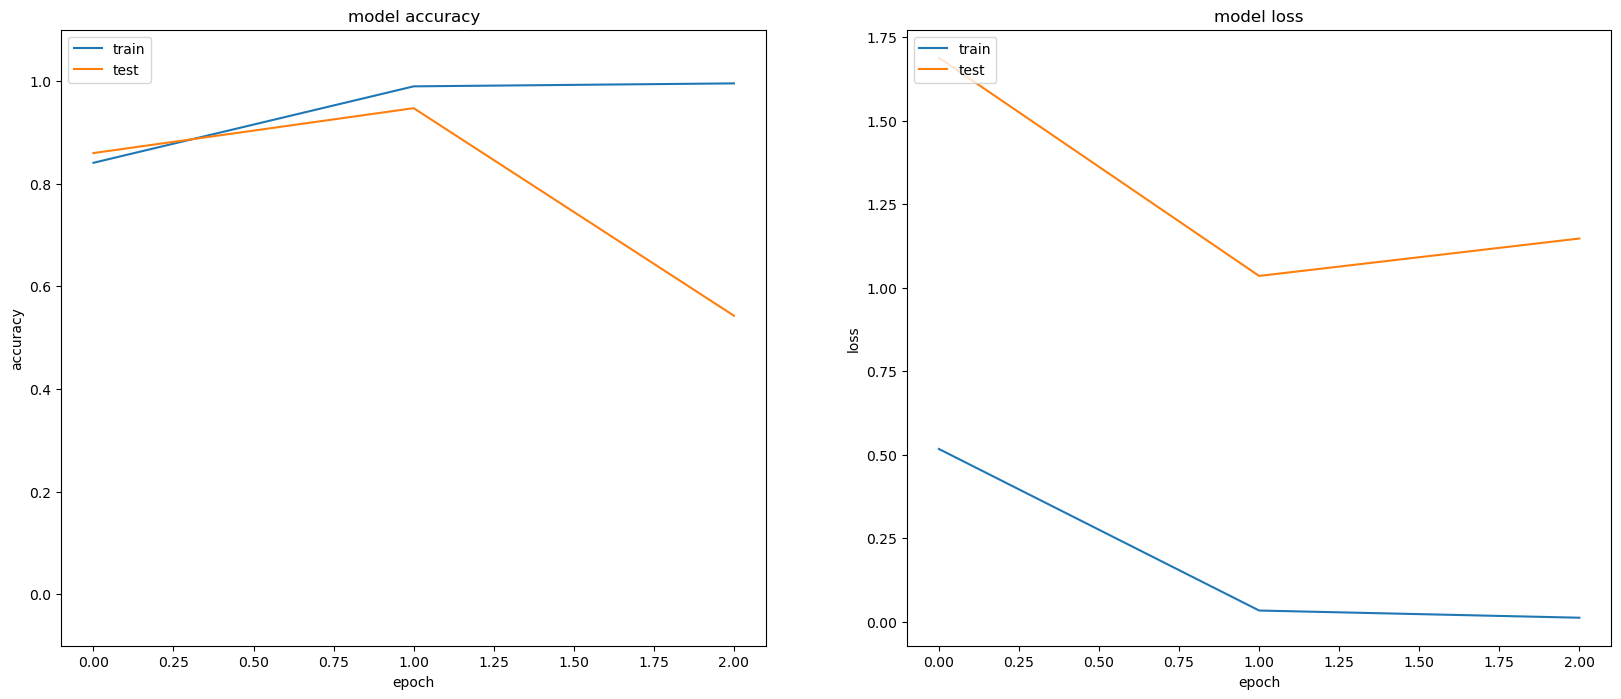

In [136]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(128, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(256, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D((2,2)),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

From this experiment we can observe that the model is not perfoming better if we exponantialy increase the number of neurons and add BatchNormalization layer as well as Maxpooling. The model is performing significantly worse than the previous experiments. We can see that in the second epoch the test has decreased significantly.

# Experiment 4

For this experiment we are using the previous structure but we are going to add some dropout layers to see if we can improve the results. We checked different techniques to see how we can improve the results from the previous model 

source:
- https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

Epoch 1/20
76/76 [==============================] - 42s 516ms/step - loss: 1.4194 - accuracy: 0.5615 - val_loss: 0.4150 - val_accuracy: 0.8894
Epoch 2/20
76/76 [==============================] - 47s 622ms/step - loss: 0.2243 - accuracy: 0.9303 - val_loss: 0.2790 - val_accuracy: 0.9356
Epoch 3/20
76/76 [==============================] - 1190s 16s/step - loss: 0.0774 - accuracy: 0.9814 - val_loss: 0.2104 - val_accuracy: 0.9373
Epoch 3: early stopping
76/76 [==============================] - 13s 175ms/step - loss: 0.0346 - accuracy: 0.9942


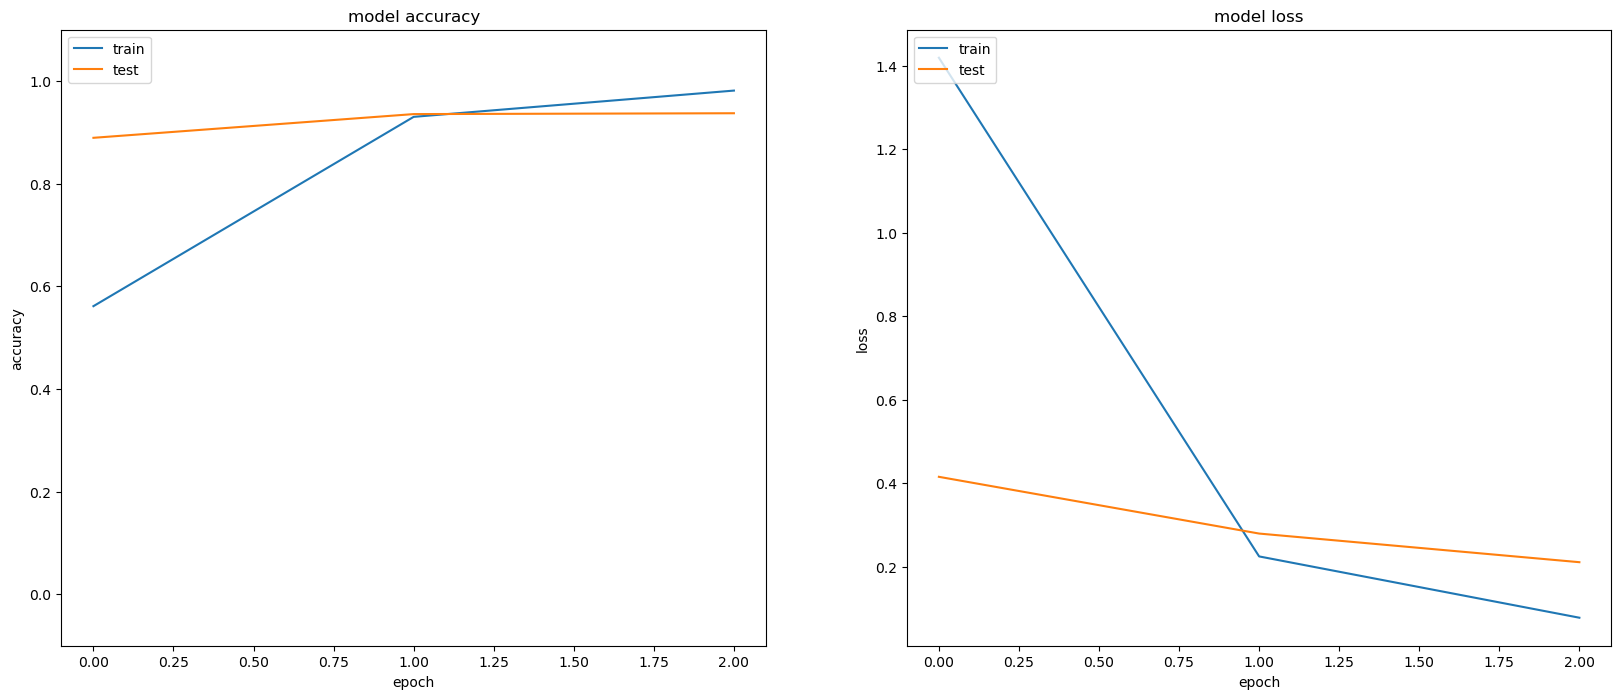

In [51]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(64,kernel_size, activation="relu"),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
])

history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

The current model looks like it's performing the best out of our all experiments. This model is similar to the first 2 experiments. It's defenitely a candidate to be exported and be further processed. This

We believe that the model would have overfitted if we would have let it more to train as the accuracy would have reached the highest value (1.0).

# Experiment 5

In our 5th experiment we added data augmentation to see if we can improve the results. As well as 3 Conv2D layers with 64 and 32 filters with BatchNormalization,  MaxPooling and Dropout. 

Epoch 1/20
76/76 [==============================] - 76s 913ms/step - loss: 2.3976 - accuracy: 0.0846 - val_loss: 2.3962 - val_accuracy: 0.1007
Epoch 2/20
76/76 [==============================] - 81s 1s/step - loss: 2.3955 - accuracy: 0.1002 - val_loss: 2.3954 - val_accuracy: 0.0842
Epoch 3/20
76/76 [==============================] - 50s 660ms/step - loss: 2.3946 - accuracy: 0.0982 - val_loss: 2.3955 - val_accuracy: 0.1155
Epoch 3: early stopping
76/76 [==============================] - 12s 156ms/step - loss: 2.3938 - accuracy: 0.1011


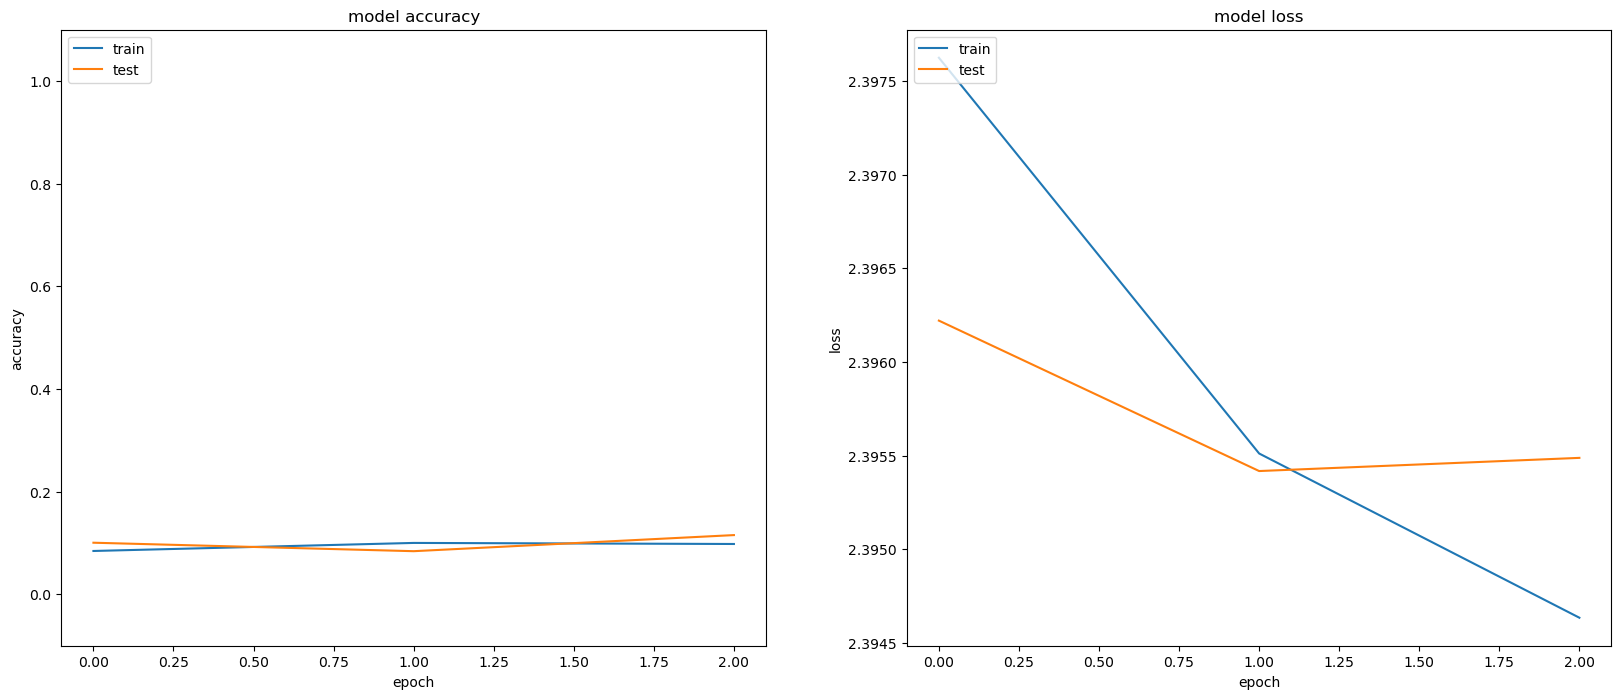

In [52]:
model = create_model(layers=[
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    
    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(32, kernel_size, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

As we can observe in the model trained above it has quit the training as it didn't make any progress for 3 epochs. Our observation is that is interesting that our model didn't perfomed better with data augmentation at all but rather worse.

We are going to try another time with some changes in the next experiment.

# Experiment 6

Our final experiment consists in 3 Conv2D layers with 64 neurons but this time we are adding BatchNormalization and Dropout.

The second experiment had an accuracy of 94% and we would like to see if we can improve it.

source:
- https://www.philschmid.de/image-classification-huggingface-transformers-keras
- https://huggingface.co/google/vit-base-patch16-224

Epoch 1/20
76/76 [==============================] - 113s 1s/step - loss: 1.5768 - accuracy: 0.4550 - val_loss: 3.4173 - val_accuracy: 0.0776
Epoch 2/20
76/76 [==============================] - 63s 833ms/step - loss: 1.0680 - accuracy: 0.6485 - val_loss: 2.2838 - val_accuracy: 0.2475
Epoch 3/20
76/76 [==============================] - 66s 859ms/step - loss: 0.9347 - accuracy: 0.6881 - val_loss: 2.3305 - val_accuracy: 0.1766
Epoch 3: early stopping
76/76 [==============================] - 12s 154ms/step - loss: 2.2933 - accuracy: 0.1885


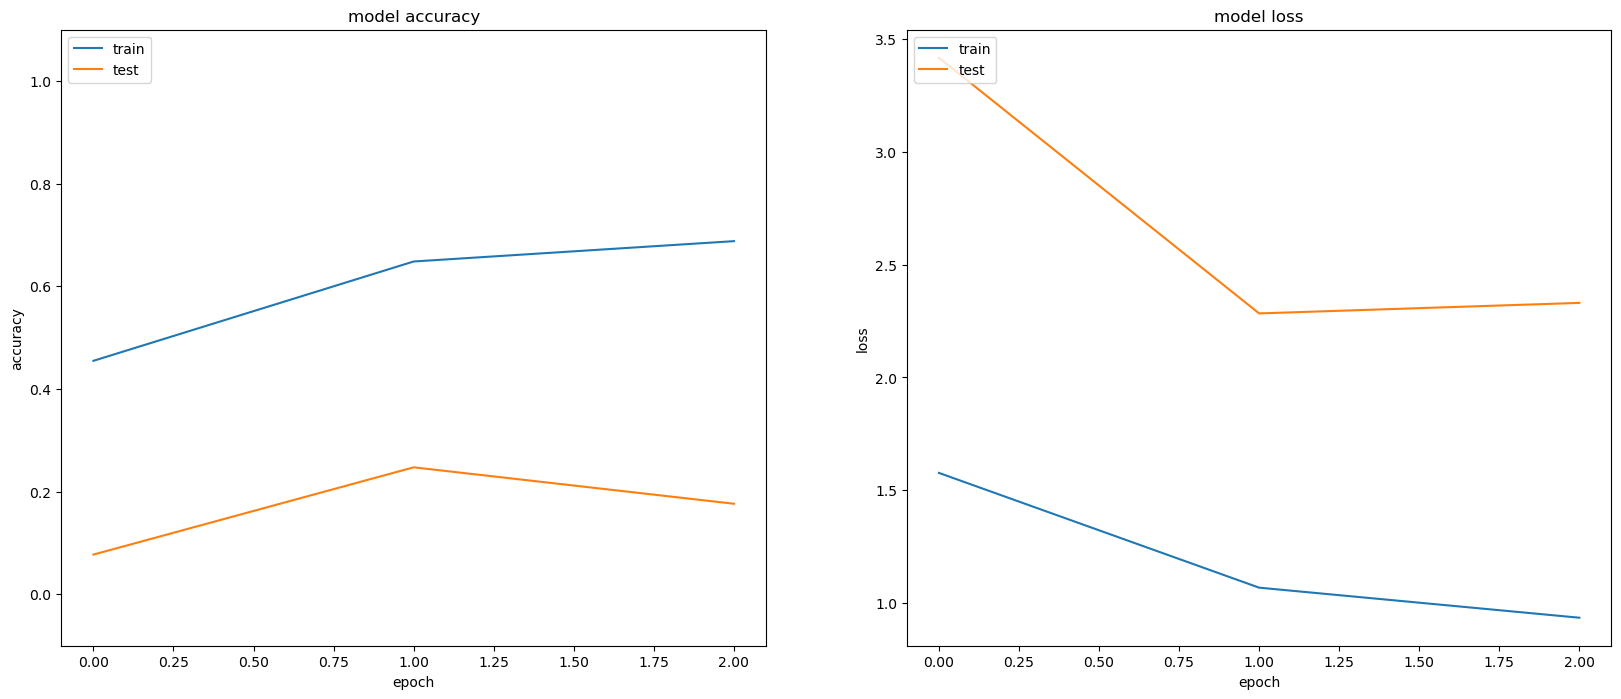

In [53]:
model = create_model(layers=[
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

Something that we have observed during our experiments is that our models are performing poorly when we add data augmentation layers, which in theory should actually improved the model. An example of those kind of cases you can see in our 6th experiment. Where our model underperforming compared tho the previous ones. Which makes us wonder if we are doing something wrong or if we are missing something.

# Experiment 7

This experiment is a result of the previous model trained with the data augmentation. We are going to use the same model but we are going to train it without the data augmentation layers. Which apparently is not helping the model to improve the results.

Epoch 1/20
76/76 [==============================] - 61s 784ms/step - loss: 0.8081 - accuracy: 0.7661 - val_loss: 1.4759 - val_accuracy: 0.6601
Epoch 2/20
76/76 [==============================] - 50s 654ms/step - loss: 0.0734 - accuracy: 0.9777 - val_loss: 1.5499 - val_accuracy: 0.6749
Epoch 3/20
76/76 [==============================] - 71s 932ms/step - loss: 0.0258 - accuracy: 0.9938 - val_loss: 0.9796 - val_accuracy: 0.7657
Epoch 3: early stopping
76/76 [==============================] - 12s 151ms/step - loss: 0.8916 - accuracy: 0.7917


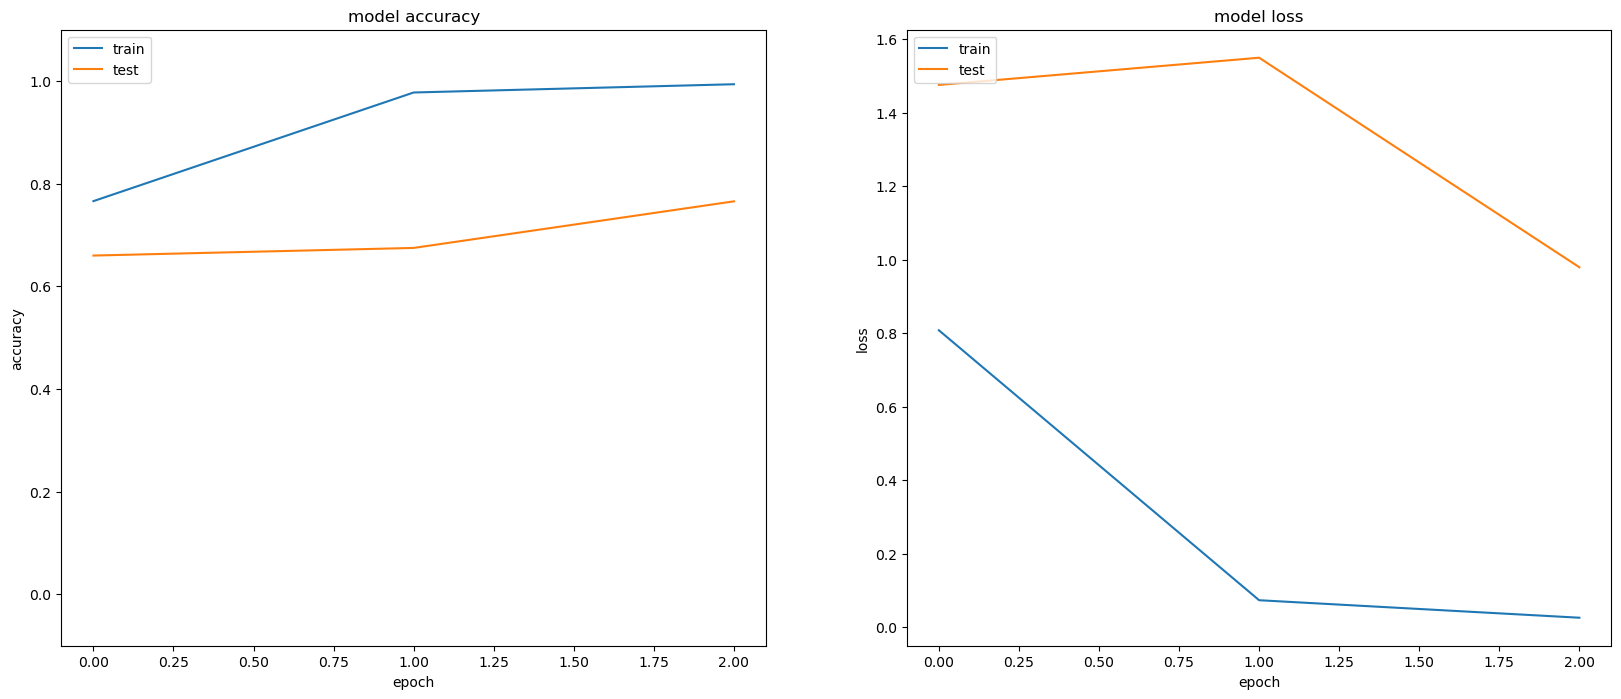

In [54]:
model = create_model(layers=[
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, kernel_size, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[early_stopping()])
evaluation_results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
plot_acc_loss(history)
models_and_history.append((model, history, evaluation_results))

As we can observe from the training the model is performing way better than the previous one. We can see that the validation accuracy is increasing and the validation loss is decreasing if we remove the augmentation layers. However, that being said the resutls obtained are not as good as the most simpliest models that we trained in Experiment 1, Experiment 3 and Experiment 4 which hit the threshhold of 99% validation accuracy. 

Checking the models that we have trained in our experiments

In [55]:
models_and_history

[(<keras.engine.sequential.Sequential at 0x2434559a100>,
  [0.006742600351572037, 1.0]),
 (<keras.engine.sequential.Sequential at 0x2434628c8b0>,
  [0.2441820204257965, 0.9455445408821106]),
 (<keras.engine.sequential.Sequential at 0x24341fdab20>,
  [0.023700054734945297, 0.9942244291305542]),
 (<keras.engine.sequential.Sequential at 0x2432dedaf70>,
  [0.03464643284678459, 0.9942244291305542]),
 (<keras.engine.sequential.Sequential at 0x24345545a00>,
  [2.3938238620758057, 0.10107260942459106]),
 (<keras.engine.sequential.Sequential at 0x243421dbc70>,
  [2.293309450149536, 0.18853135406970978]),
 (<keras.engine.sequential.Sequential at 0x24341b256a0>,
  [0.8915795087814331, 0.7916666865348816])]

# Exporting the best model

In [140]:
best_model, model_history, evaluation_results = models_and_history[3]

Displaying the loss and accuracy of the best model

In [139]:
loss, accuracy = evaluation_results

print(f"Loss: {loss:.7f} - accuracy: {accuracy:.7f}")

Loss: 0.0185992 - accuracy: 0.9942244


Saving the model

In [64]:
best_model.save('best_model_cnn')

INFO:tensorflow:Assets written to: best_model_cnn\assets


Loading the model

In [14]:
model = keras.models.load_model('best_model_cnn')

In the following section we are going to use the best model that we have trained and we are going to use it to evaluate it against the test and train dataset.

In [18]:
loss_train, accuracy_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
loss_test, accuracy_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"Train: Loss: {loss_train:.7f} - accuracy: {accuracy_train:.7f}")
print(f"Test: Loss: {loss_test:.7f} - accuracy: {accuracy_test:.7f}")

19/19 [==============================] - 4s 195ms/step - loss: 0.2104 - accuracy: 0.9373
Train: Loss: 0.0346464 - accuracy: 0.9942244
Test: Loss: 0.2104235 - accuracy: 0.9372937


As we can see the model is performing quite well on both datasets. The accuracy for the train is slightly higher compared to the test one.
But is a bit less than in the accuracy that we had during the training.

Analisys of the model

In the following sections we are going to plot some metrics for our best model and run some random tests.

First of all we are dispaying the summary of the model to check what and how many layers our model has.

In [44]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 30, 30, 64)      

In the section above we can see a summary of the model and what kind of layers has.

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def analyse_my_model(model):
    print("\n")
    # Source for this fix https://datascience.stackexchange.com/a/93773 
    y_test_arg=np.argmax(y_test,axis=1)
    Y_pred = np.argmax(model.predict(X_test),axis=1)
    print(confusion_matrix(y_test_arg, Y_pred))
    print("\n")
    print(classification_report(y_true=y_test_arg,y_pred=Y_pred, target_names=np.unique(labels),zero_division=0))
    print("\n")

In [88]:
analyse_my_model(model)



[[45  0  0  0  0  0  3  0  0  0  0]
 [ 0 41  0  1  0  0  0  0  0  0  0]
 [ 0  0 74  0  0  0  1  0  1  0  0]
 [ 0  3  0 62  0  2  1  1  0  0  1]
 [ 1  0  0  1 45  0  0  0  0  0  0]
 [ 0  2  0  4  0 44  1  0  0  0  0]
 [ 0  1  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  3  0  2 37  0  1  0]
 [ 0  0  0  2  0  1  2  0 57  0  0]
 [ 0  1  0  0  0  0  0  0  0 60  0]
 [ 0  0  0  0  2  0  0  0  0  0 49]]


              precision    recall  f1-score   support

         ash       0.98      0.94      0.96        48
       birch       0.85      0.98      0.91        42
       earth       1.00      0.97      0.99        76
      estate       0.89      0.89      0.89        70
         ice       0.90      0.96      0.93        47
         ing       0.94      0.86      0.90        51
         joy       0.84      0.98      0.91        55
        need       0.97      0.86      0.91        43
     serpent       0.98      0.92      0.95        62
       stone       0.98      0.98      0.98        61
    

# Testing the model

Finally we are going to test the model with some images that we "generated" with the server from Introduction to Machine Learning. We are going to use only 10 images to test the model.

We're using the display function from IML to display the images predicted by the model.

In [205]:
def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

LEt's load the test dataset into new arrays

In [199]:
images_testing = []
labels_testing = []
data_path = './generated_images/'
for file_name in listdir(data_path):
    full_path = join(data_path, file_name)
    if isfile(full_path):
        if re.match(r".*\.png$", full_path):
            image_current = io.imread(full_path, as_gray=True)
            image_label = file_name.split('_')[0].lower()
            # append to the array
            images_testing.append(image_current)
            labels_testing.append(image_label)

Let's predict the images and display the results

In [202]:
labels_predicted = model.predict(np.asarray(images_testing).astype('float32'))

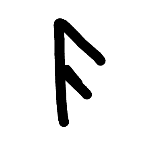

Image 0 is ash and is predicted to be a ash


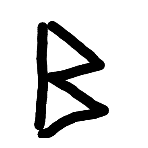

Image 1 is ash and is predicted to be a birch


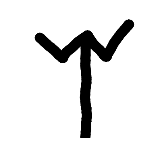

Image 2 is ash and is predicted to be a earth


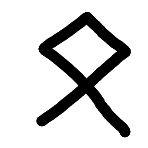

Image 3 is ash and is predicted to be a estate


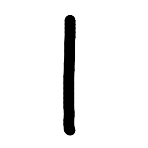

Image 4 is ash and is predicted to be a ice


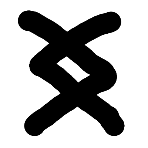

Image 5 is ash and is predicted to be a ing


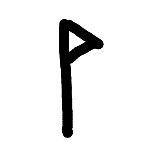

Image 6 is ash and is predicted to be a joy


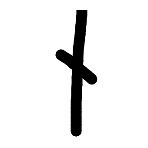

Image 7 is ash and is predicted to be a need


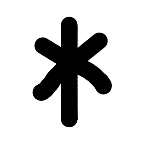

Image 8 is ash and is predicted to be a serpent


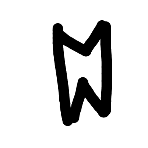

Image 9 is ash and is predicted to be a stone


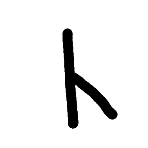

Image 10 is ash and is predicted to be a torch


In [207]:
for index in range(0, len(labels_predicted)):
    display(images_testing[index])
    print(f"Image {index} is {labels[index] } and is predicted to be a {np.unique(labels_testing)[np.argmax(labels_predicted, axis=1)[index]]}")

As we can observe our model has predicted correctly all the images. Which is a good sign that our model is performing as expected. 

# Conclusion

During our experiments we have encountered different situations where our model performed or not as we expected. In the beginning of our experiments the models we have tried different configurations of layers with different number of neurons and different techniques to avoid overfitting, such as using a early stopping callback, dropout layers and data augmentation. 

As an observation, the most simple model that we have trained in Experiment 2, Experiment 3 and Experiment 4 had the best results. Something that we couldn't figure out is why the models with the data augmentation were performing worse than the models without. 

In addition to that, the literature that we have checked says that by adding data augmentation, dropout layers and early stopping callbacks we should be able to avoid overfitting. Nevertheless, the we also noticed at some point that we have started training with a very small loss function and in fact for the validation it was higher than the training loss. Same thing happened with the accuracy, training accuracy was quite high and in the validation was lower.

In the end we have trained a model that is able to classify the images with an accuracy of 94% which is quite good. However, we would like to improve the results in the feature and we belive that it is possible to improve the results. Something that we should take into account next time is that if the grayscale do make a difference when it comes to training and testing. That's something that we've done during introduction to machine learning as well.
